In [ ]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation, CLIPSegModel

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
model = model.to(device)

In [ ]:
COLOR_MAP = dict({
    # 'background': (0, 0, 0),
    'ship': (0, 0, 63),
    'storage tank': (0, 191, 127),
    'baseball diamond': (0, 63, 0),
    'tennis court': (0, 63, 127),
    'basketball court': (0, 63, 191),
    'ground track field': (0, 63, 255),
    'bridge': (0, 127, 63),
    'large vehicle': (0, 127, 127),
    'small vehicle': (0, 0, 127),
    'helicopter': (0, 0, 191),
    'swimming pool': (0, 0, 255),
    'roundabout': (0, 63, 63),
    'soccer ball field': (0, 127, 191),
    'plane': (0, 127, 255),
    'harbor': (0, 100, 155),
})

prompts = list(COLOR_MAP.keys())
class_num = len(prompts)
color = torch.tensor(list(COLOR_MAP.values()), dtype=torch.uint8).to(device)
threshold = 0.3
print(prompts)

In [175]:
def get_pred(image_np, debug=0):
  image_ori = Image.fromarray(image_np)
  final_shape = np.ceil(np.array(image_np.shape)[0:2]/352).astype(np.int32)*352
  final_shape = (class_num, final_shape[0], final_shape[1])
  final_pred = torch.zeros(final_shape).to(device)
  # maybe use unfold
  for w_start in range(0, final_shape[2], 352):
    for h_start in range(0, final_shape[1], 352):
      image = image_ori.crop((w_start, h_start, 352+w_start, 352+h_start))
      inputs = processor(text=prompts, images=[image] * class_num, padding="max_length", return_tensors="pt")
      inputs = inputs.to(device)
      # predict
      with torch.no_grad():
        outputs = model(**inputs)
      # visualize prediction
      preds = outputs.logits
      final_pred[:, h_start:h_start+352, w_start:w_start+352] = preds
      if not debug:
        continue
      display(image)
      _, ax = plt.subplots(1, class_num+1, figsize=(20, 20))
      [a.axis('off') for a in ax.flatten()]
      ax[0].imshow(image_ori)
      p = preds.sigmoid()
      for i in range(class_num):
          res = p[i].to('cpu')
          ax[i+1].imshow(res)
      [ax[i+1].text(0, -15, prompts[i]) for i in range(class_num)];
      plt.show()
      prob, pred = p.max(dim=0)
      ans_map = color[pred]
      # 置信度低的标签为背景
      ans_map[prob<threshold] = 255
      img = Image.fromarray(ans_map.to('cpu').numpy(), mode='RGB')
      display(img)
  
  final_pred = final_pred[:, :image_ori.height, :image_ori.width]
  return final_pred.sigmoid()

In [182]:
# visualize prediction
def vis(image_np, final_pred, threshold_list = [0.3]):
    image_ori = Image.fromarray(image_np)
    prob, pred = final_pred.max(dim=0)
    # 置信度低的标签为背景

    for threshold in threshold_list:
        ans_map = color[pred].clone()
        ans_map[prob<threshold] = 255
        img = Image.fromarray(ans_map.cpu().numpy(), mode='RGB')
        display(Image.blend(image_ori, img, 0.6))
        ans_map[prob<threshold] = 0
        img = Image.fromarray(ans_map.cpu().numpy(), mode='RGB')
        display(Image.blend(image_ori, img, 1))

In [ ]:
image_path = 'isaid_segm/val/images/images/P0003.png'
image_ori = Image.open(image_path)
final_pred = get_pred(np.array(image_ori))
vis(np.array(image_ori), final_pred, prompts)

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
from data.farseg import RemoveColorMap

cm = RemoveColorMap()


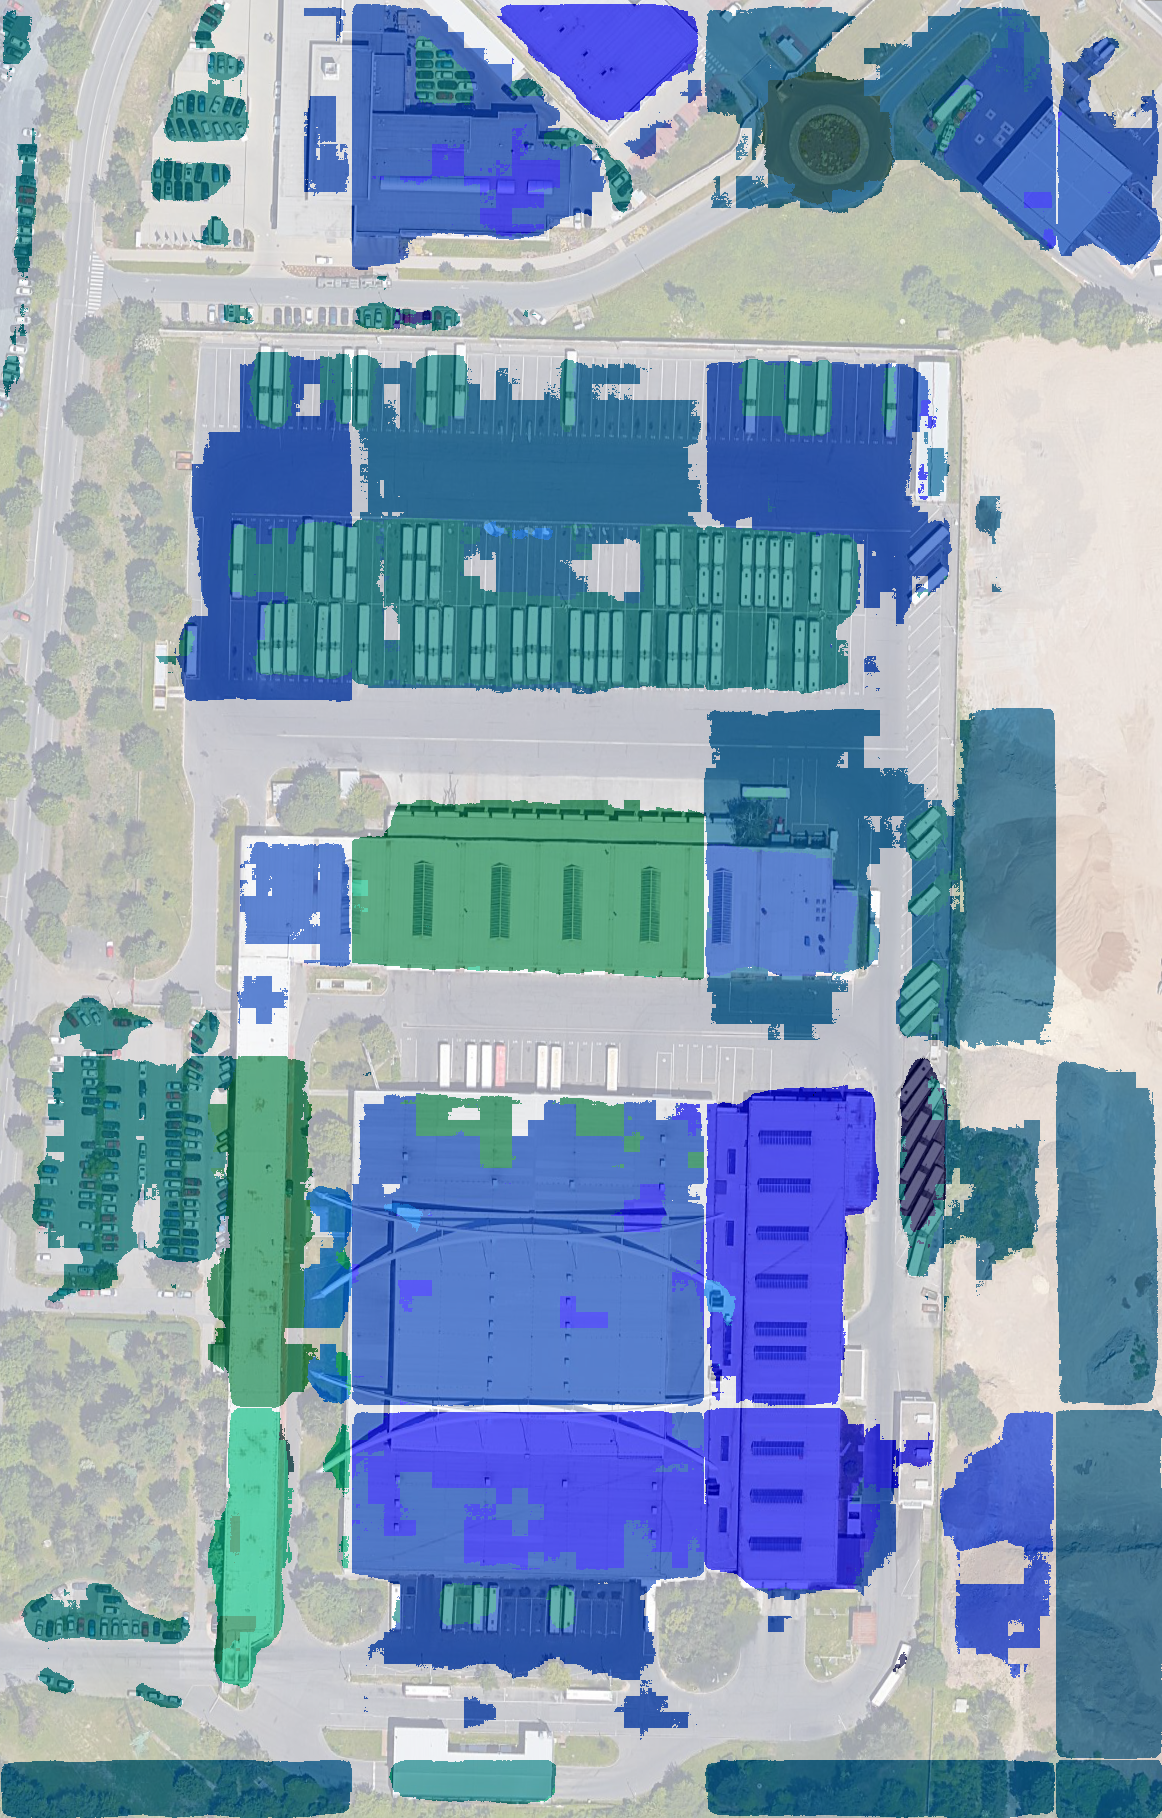

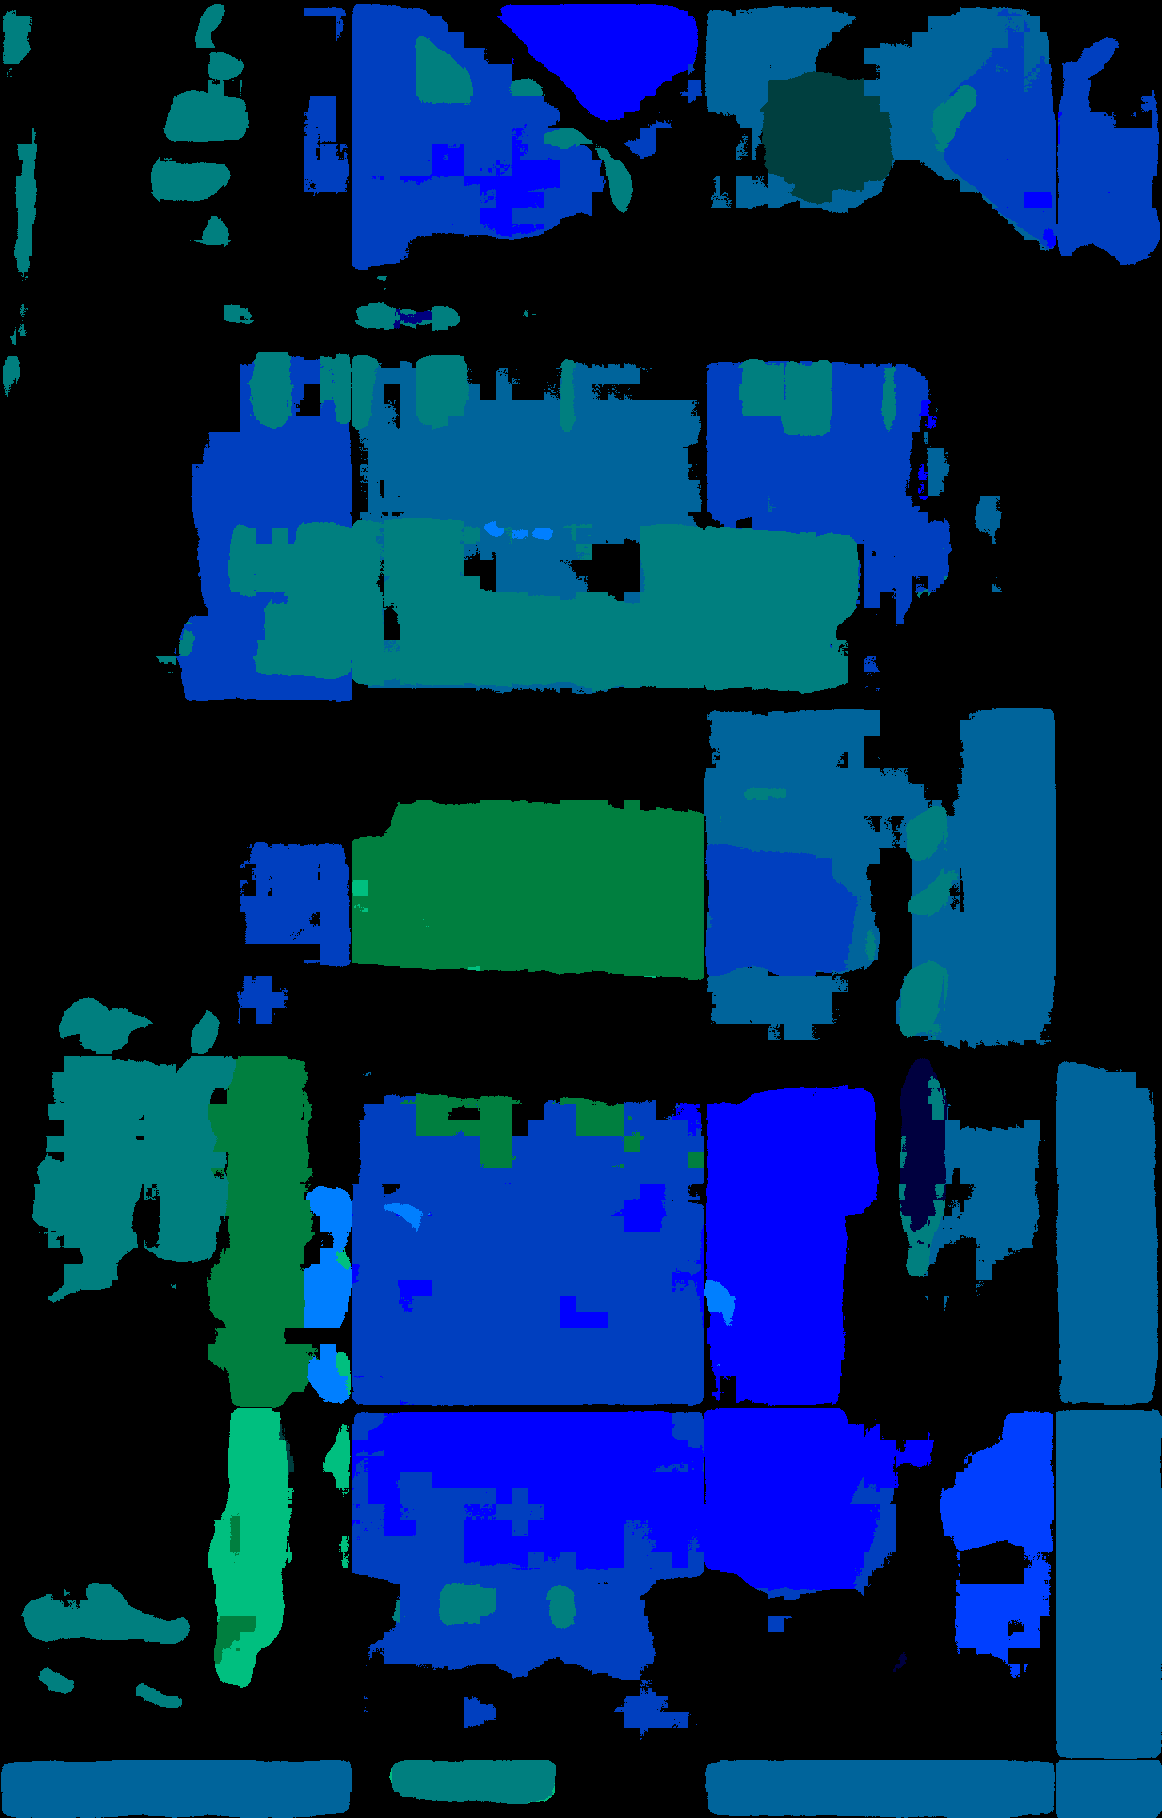

In [183]:

from data.farseg import ImageFolderDataset

dataset = ImageFolderDataset(img_dir='isaid_segm/val/images/images', mask_dir='isaid_segm/val/masks/images')

img, gt, filename = dataset[3]
pred = get_pred(img)
vis(img, pred)


In [181]:
print(filename)

P1992.png
